
Cointegration Analysis:
'sz399373', 'sh000079' are cointegrated
Hedge ratio: 2.7704


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


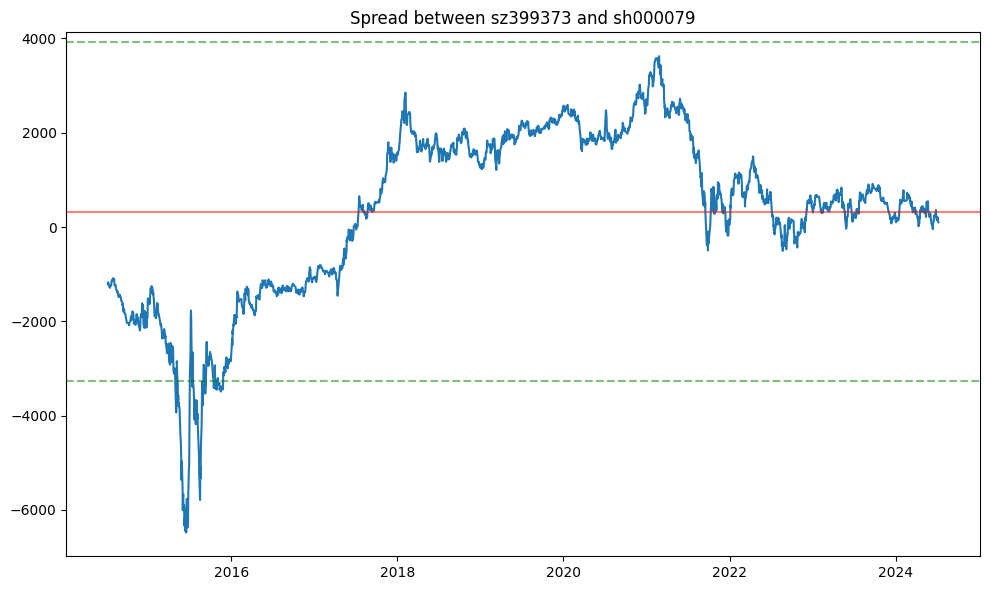

/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


'sz399373', 'sz399433' are cointegrated
Hedge ratio: 3.3206


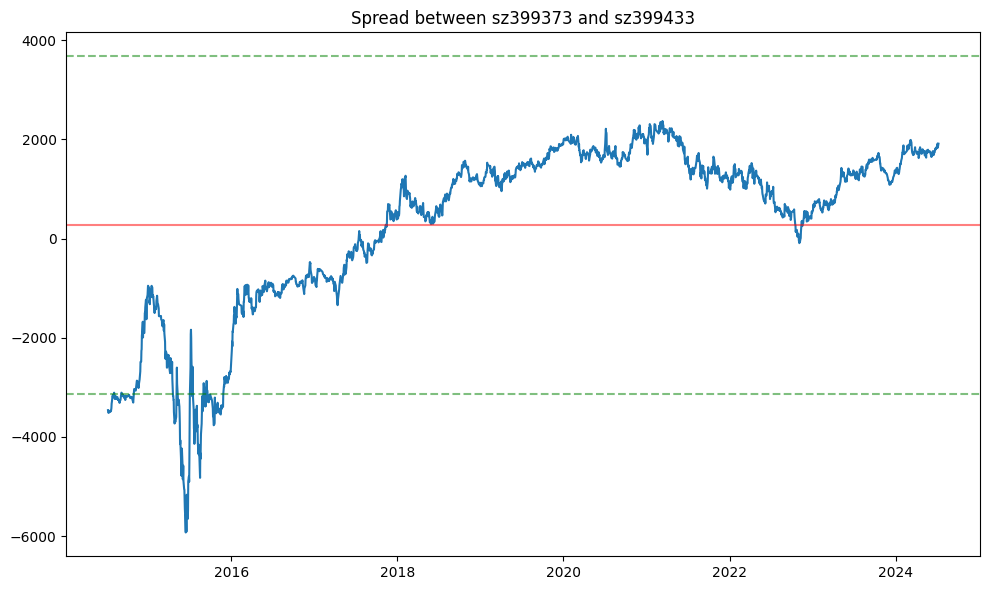

'sz399373', 'sz399992' are cointegrated
Hedge ratio: 3.5486


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


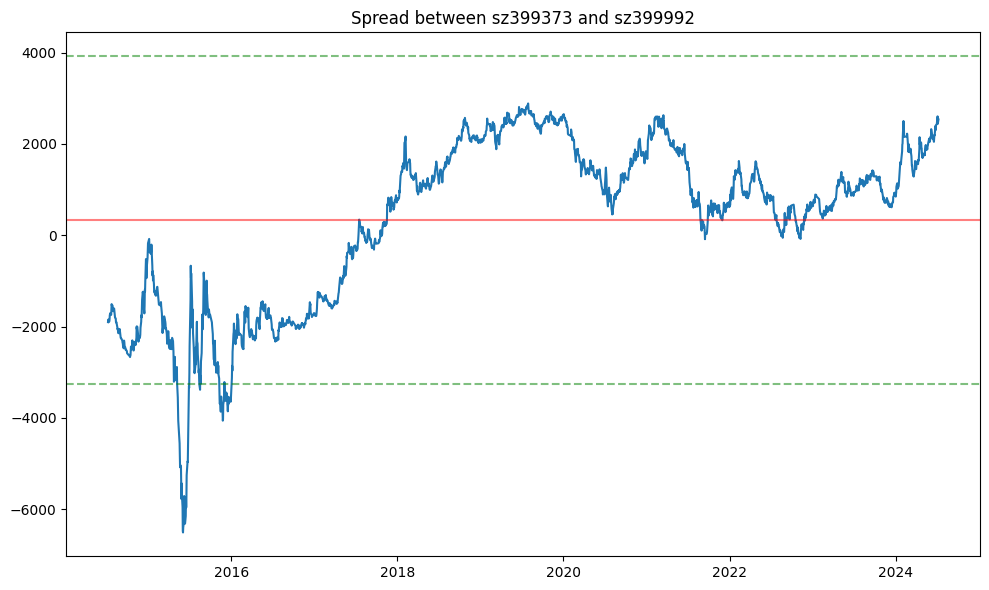

'sz399373', 'sz399239' are cointegrated
Hedge ratio: 3.2058


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


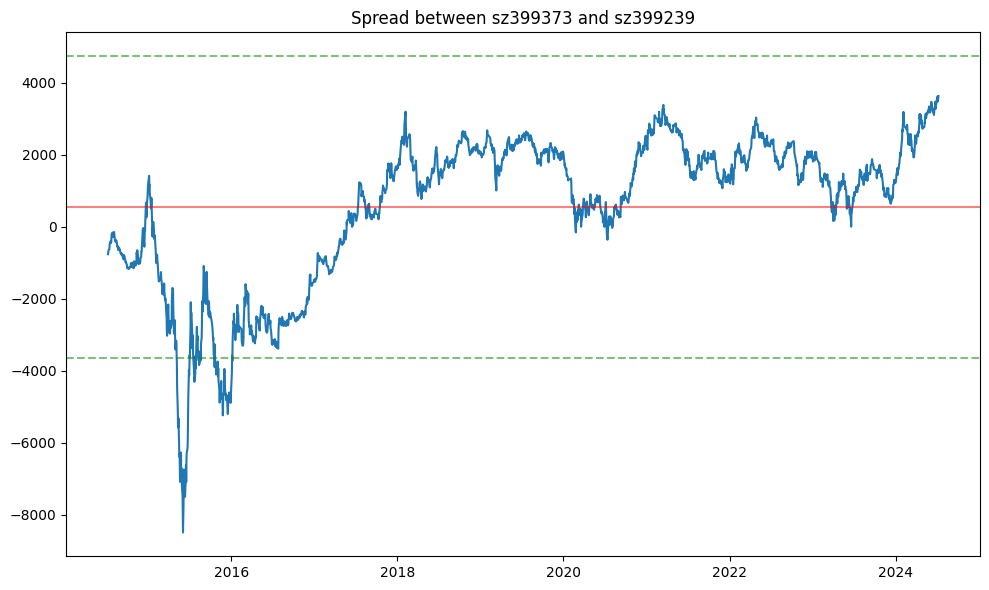

'sz399373', 'sz980032' are cointegrated
Hedge ratio: 0.6151


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


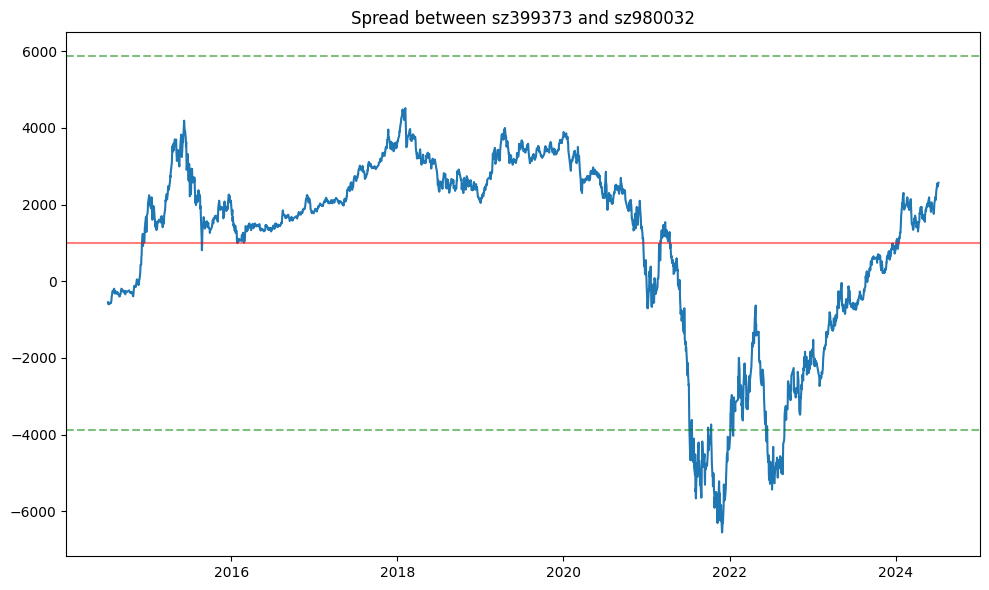

'sz399373', 'sz399971' are cointegrated
Hedge ratio: 3.4953


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


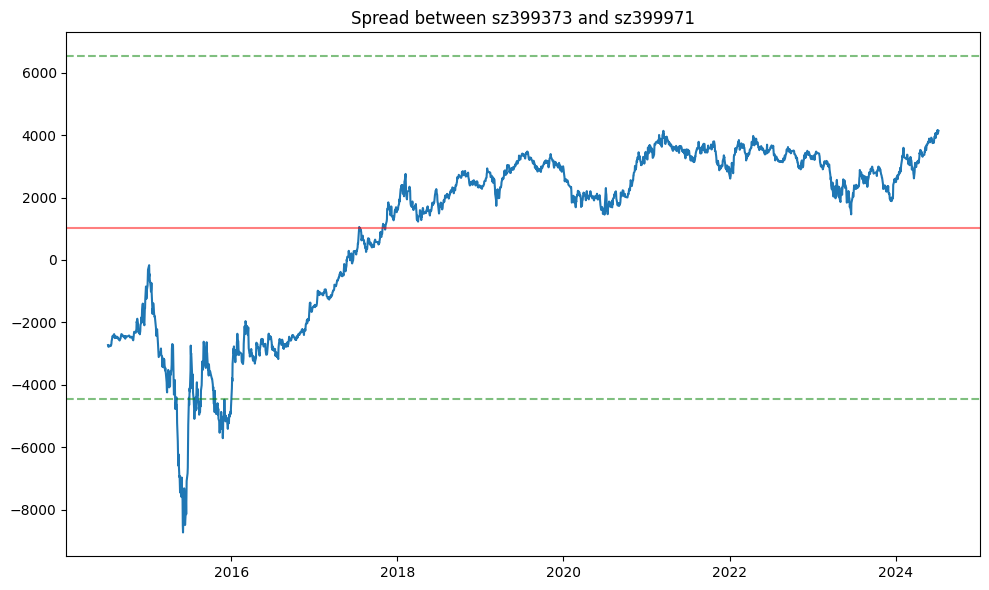

'sz399373', 'sz399973' are cointegrated
Hedge ratio: 3.9386


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


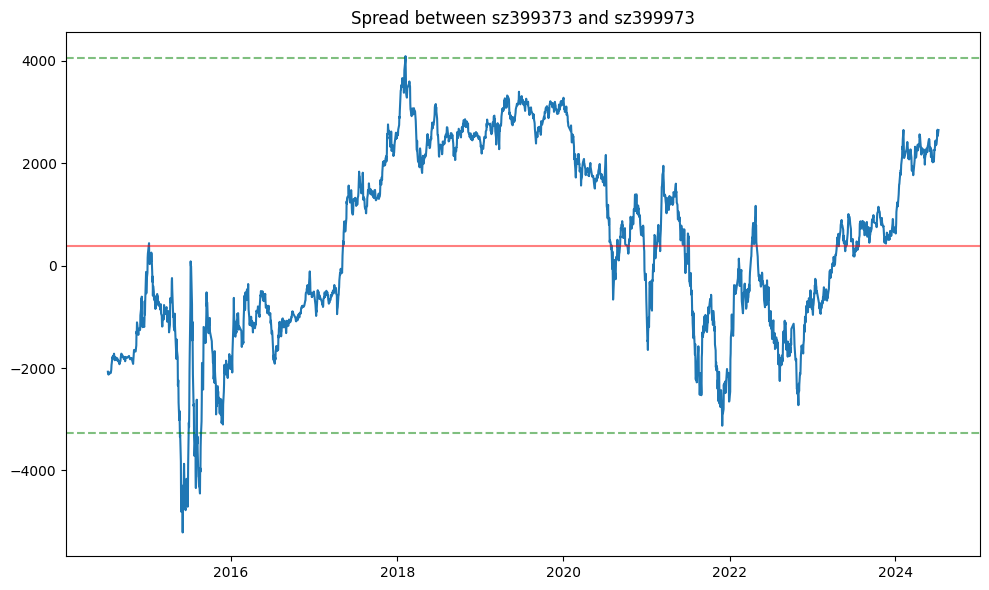

'sz399373', 'sz399242' are cointegrated
Hedge ratio: 3.5725


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


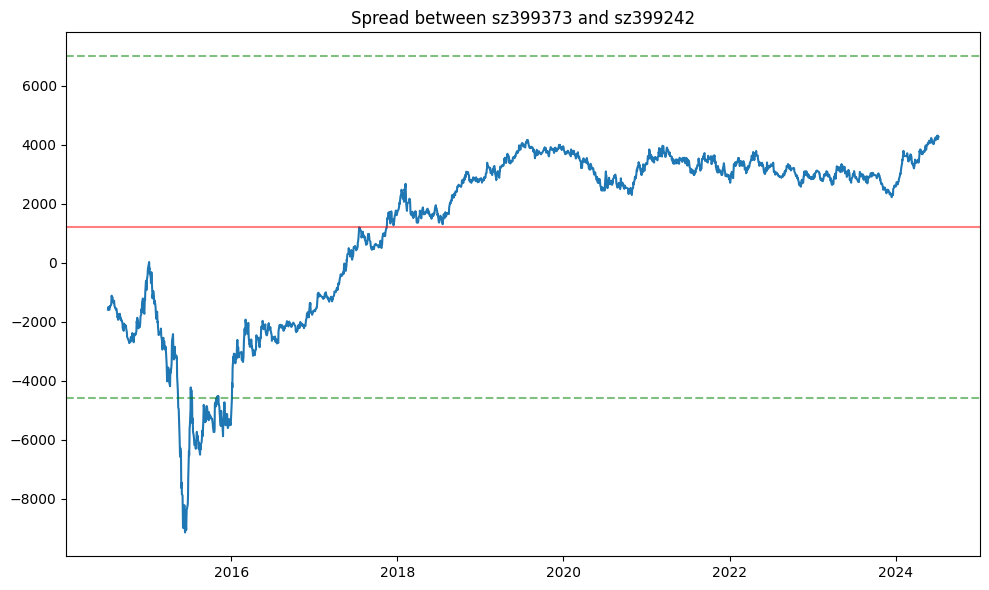

'sz399373', 'sz399434' are cointegrated
Hedge ratio: 1.8348


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


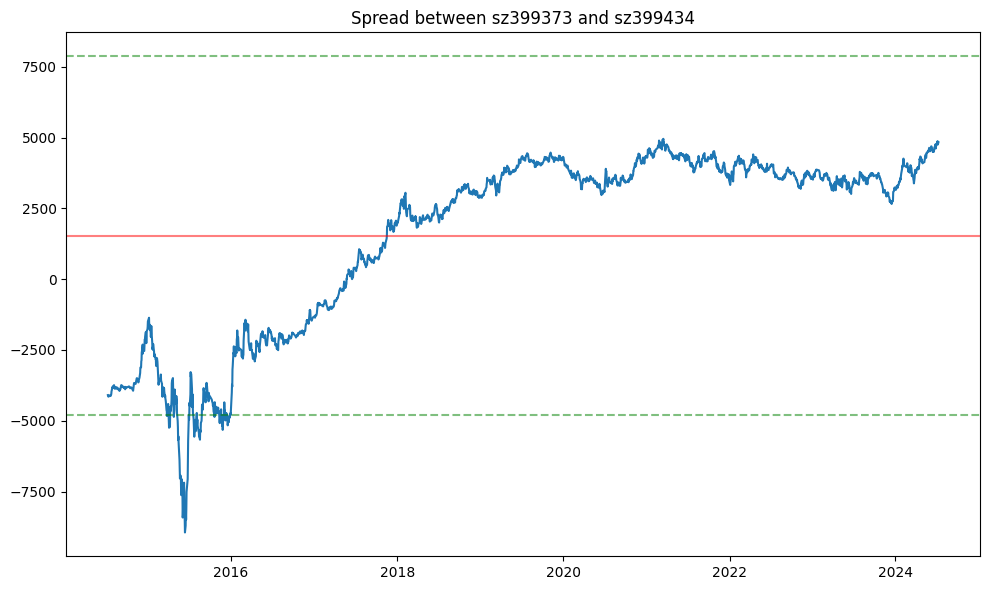

'sz399992', 'sz399242' are cointegrated
Hedge ratio: 1.0604


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


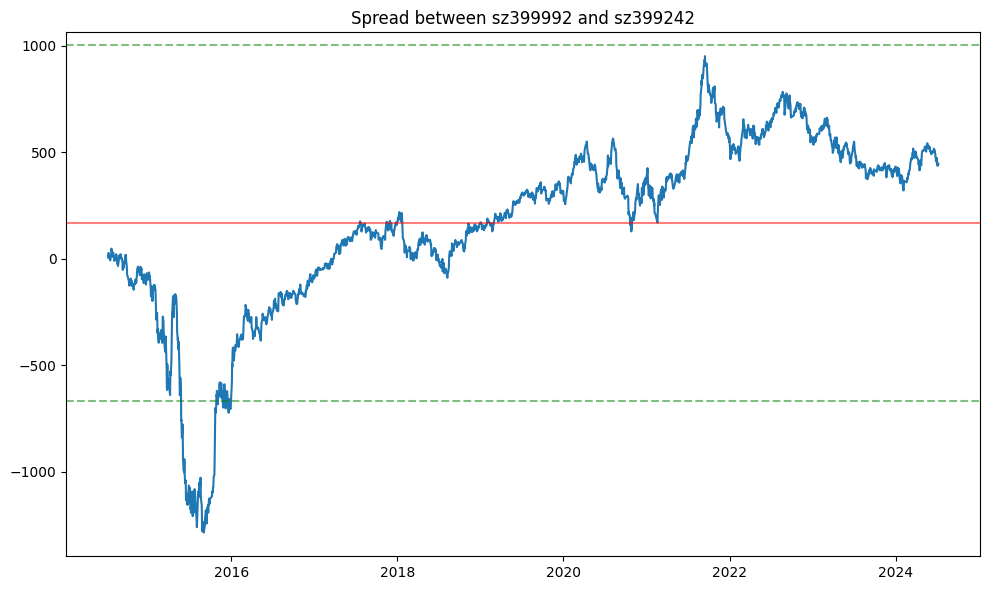

'sz399992', 'sz399434' are cointegrated
Hedge ratio: 0.5549


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


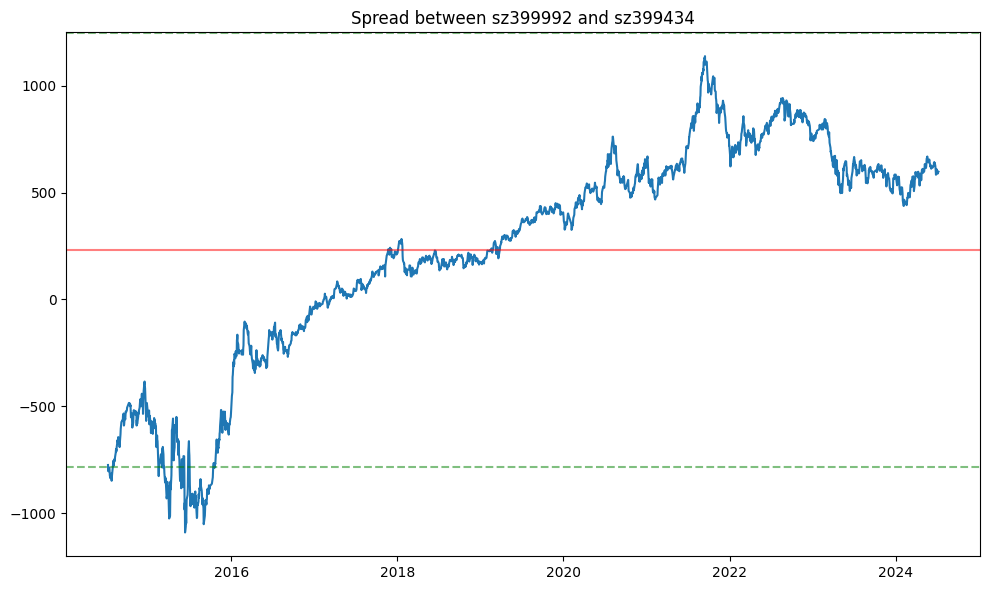

'sz399996', 'sz399277' are cointegrated
Hedge ratio: 0.8870


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


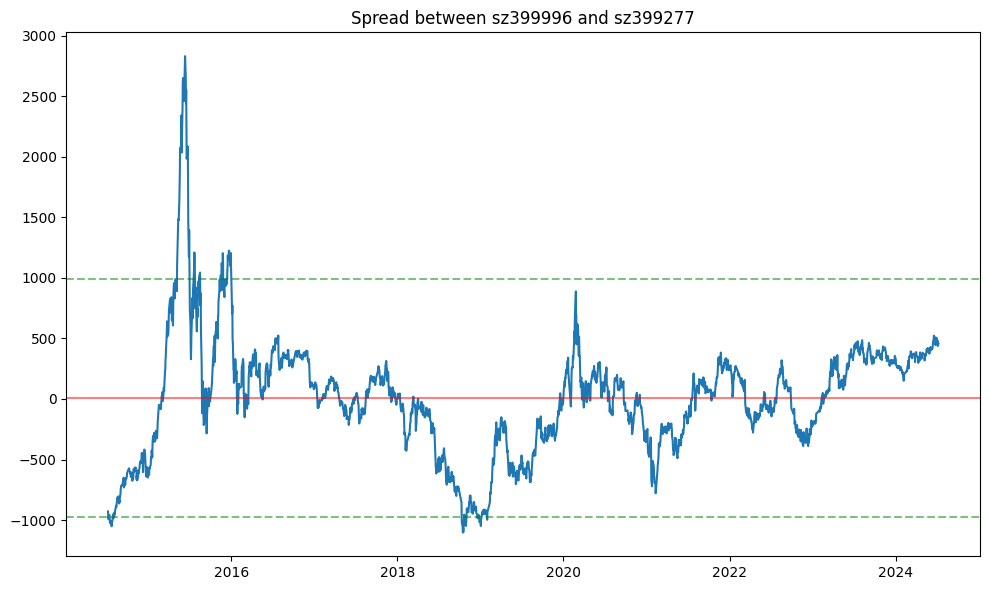

'sz399996', 'sz980032' are cointegrated
Hedge ratio: 0.2582


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


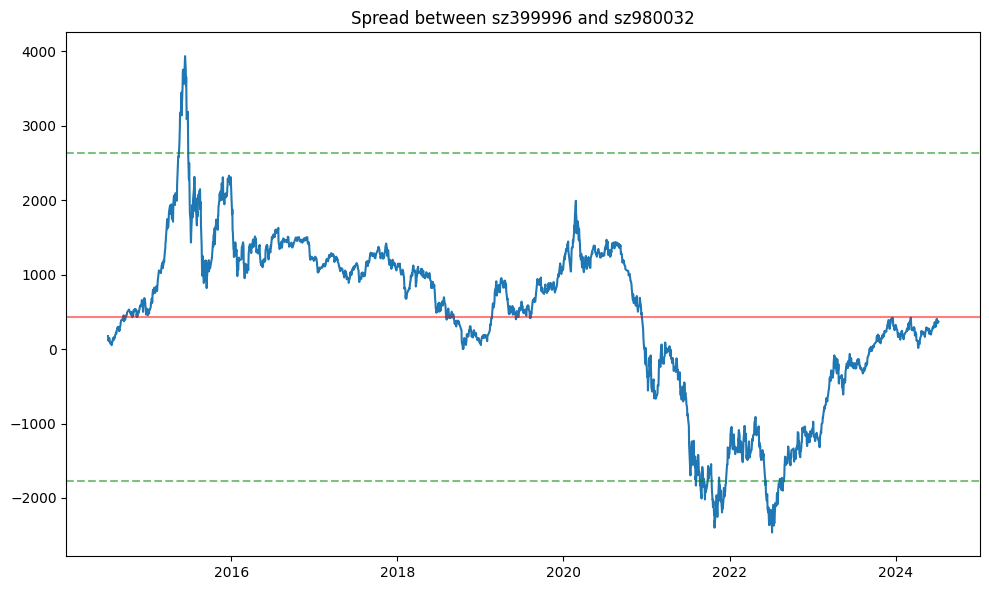

'sz399996', 'sz399973' are cointegrated
Hedge ratio: 1.7152


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


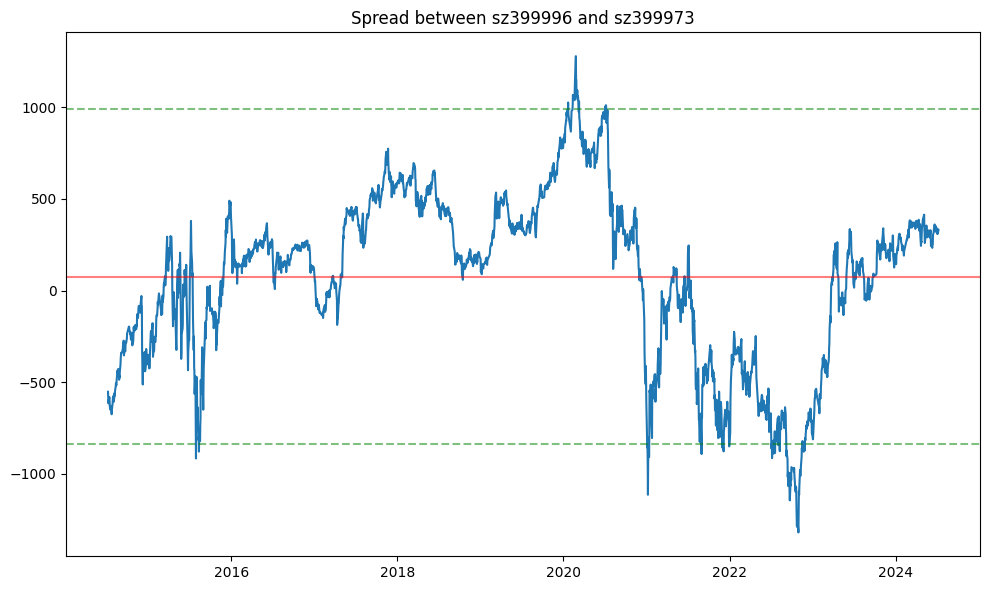

'sz399996', 'sz399242' are cointegrated
Hedge ratio: 1.6094


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


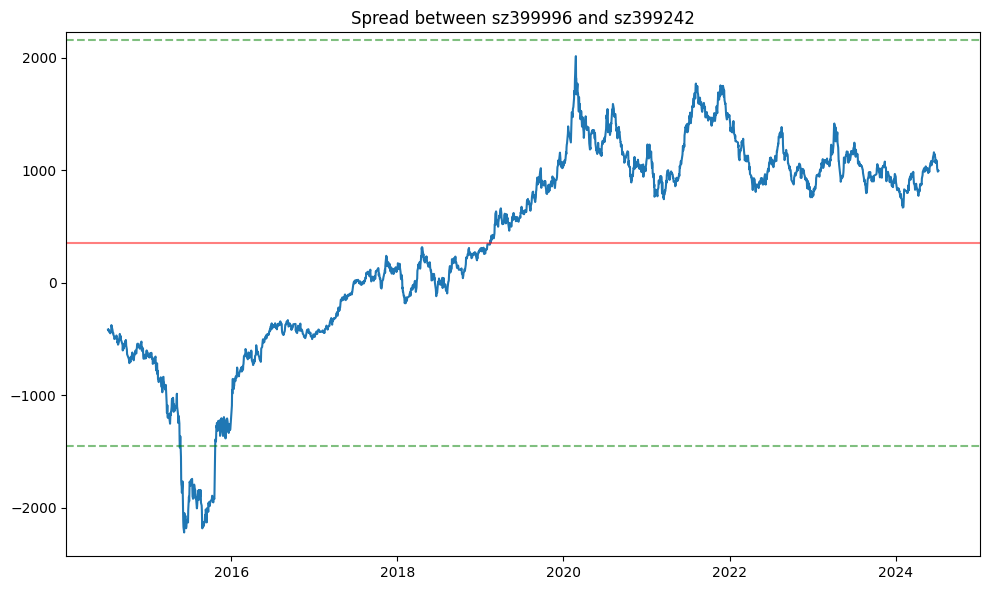

'sz399996', 'sz399434' are cointegrated
Hedge ratio: 0.8336


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


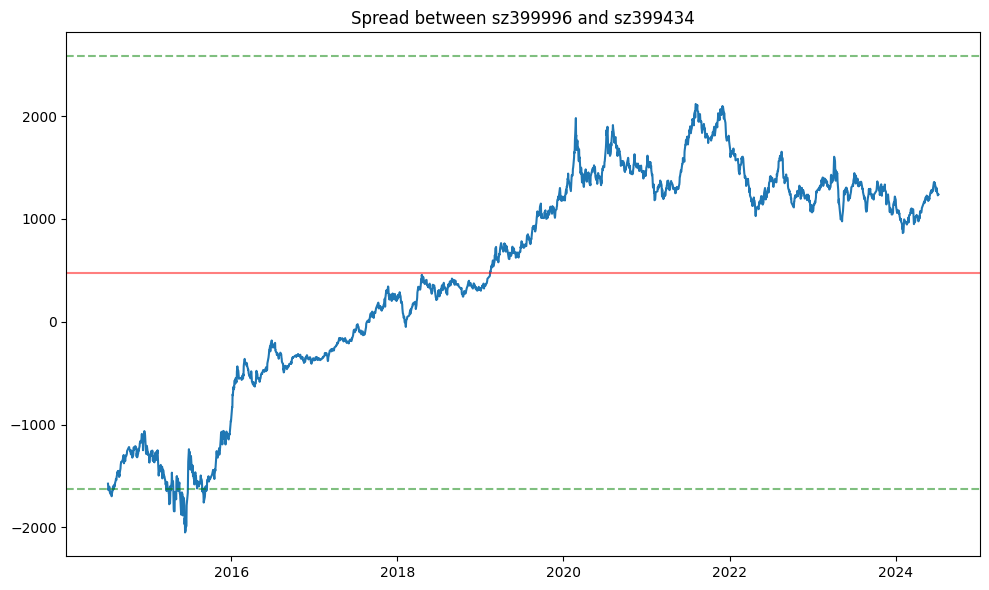

'sz399358', 'sz980032' are cointegrated
Hedge ratio: 0.4126


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


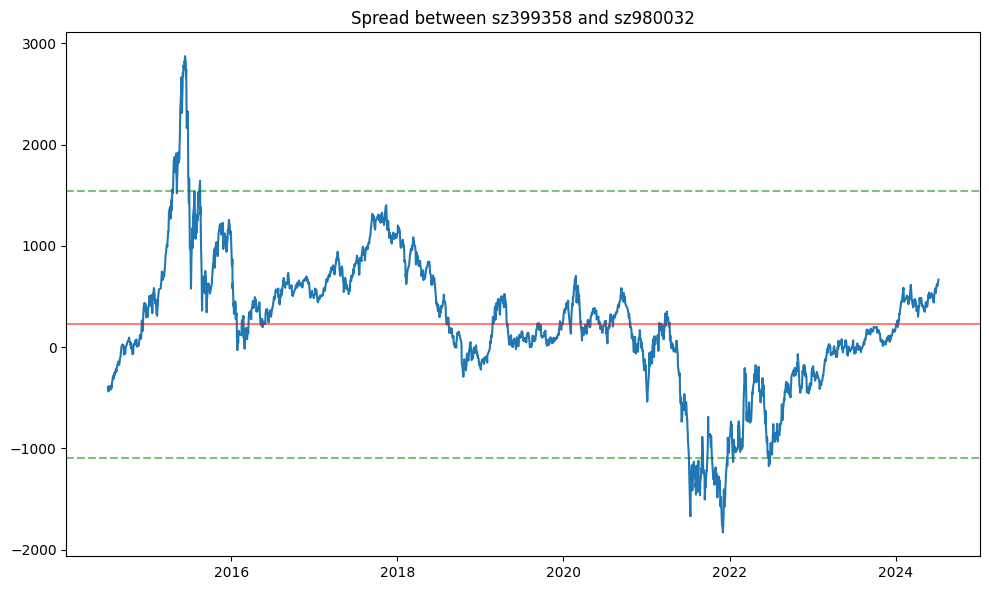

'sz399239', 'sz399971' are cointegrated
Hedge ratio: 1.1308


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


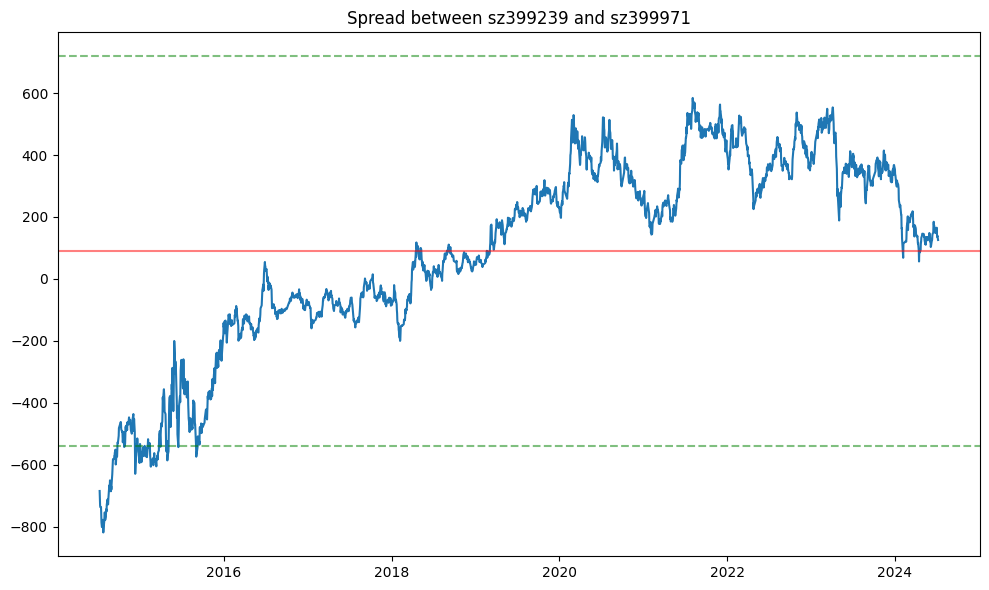

'sz399239', 'sz399242' are cointegrated
Hedge ratio: 1.1656


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


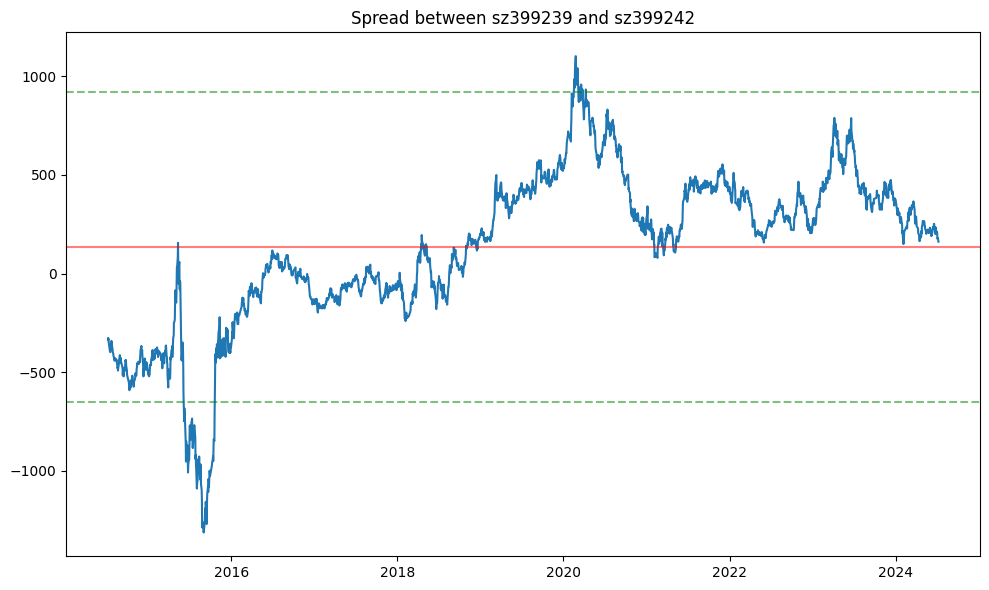

'sz399239', 'sz399434' are cointegrated
Hedge ratio: 0.6096


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


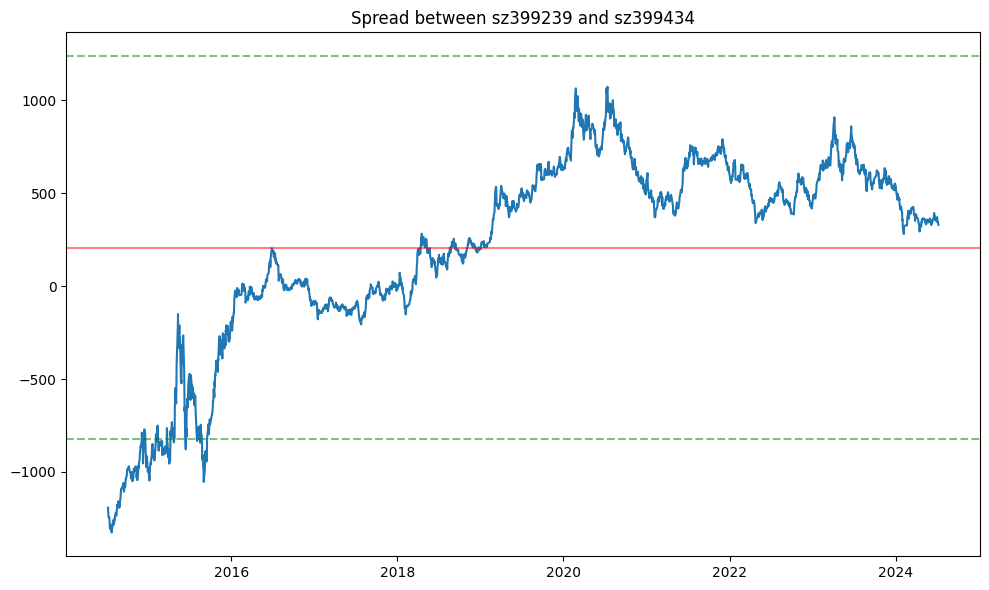

'sz399615', 'sz399973' are cointegrated
Hedge ratio: 2.0313


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


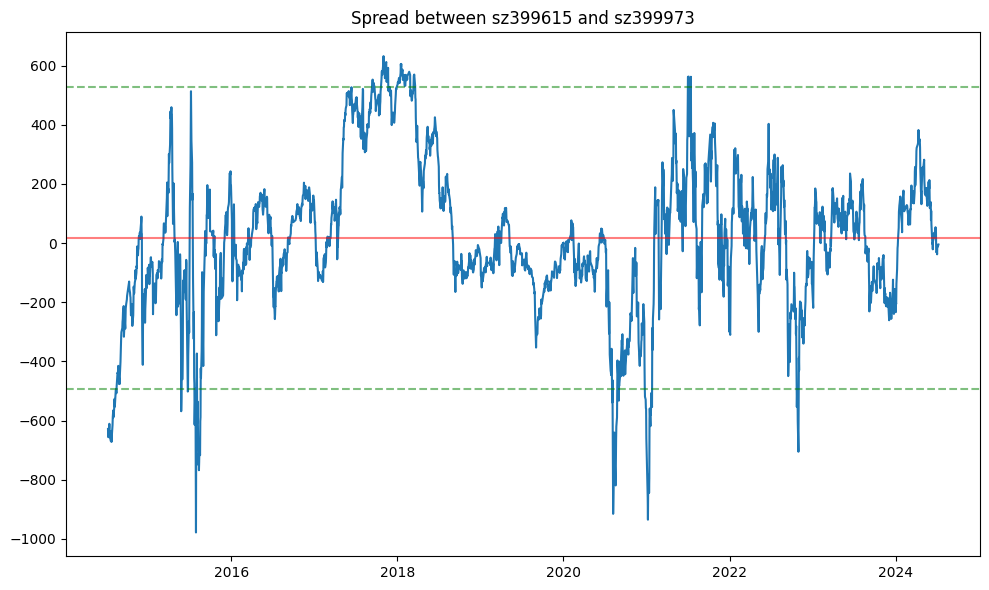

'sh000989', 'sz399242' are cointegrated
Hedge ratio: 2.9575


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


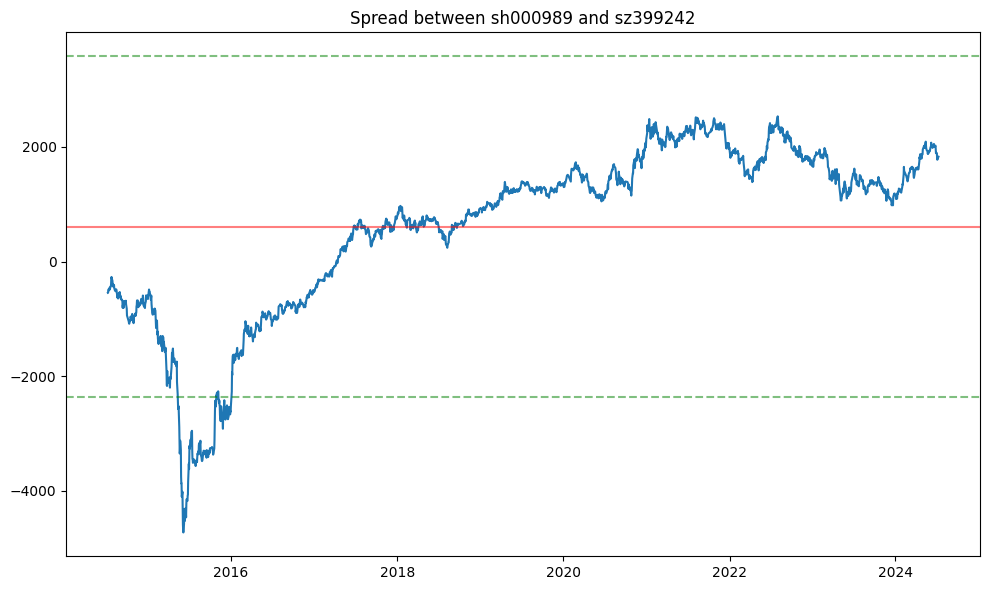

'sh000989', 'sz399434' are cointegrated
Hedge ratio: 1.5365


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


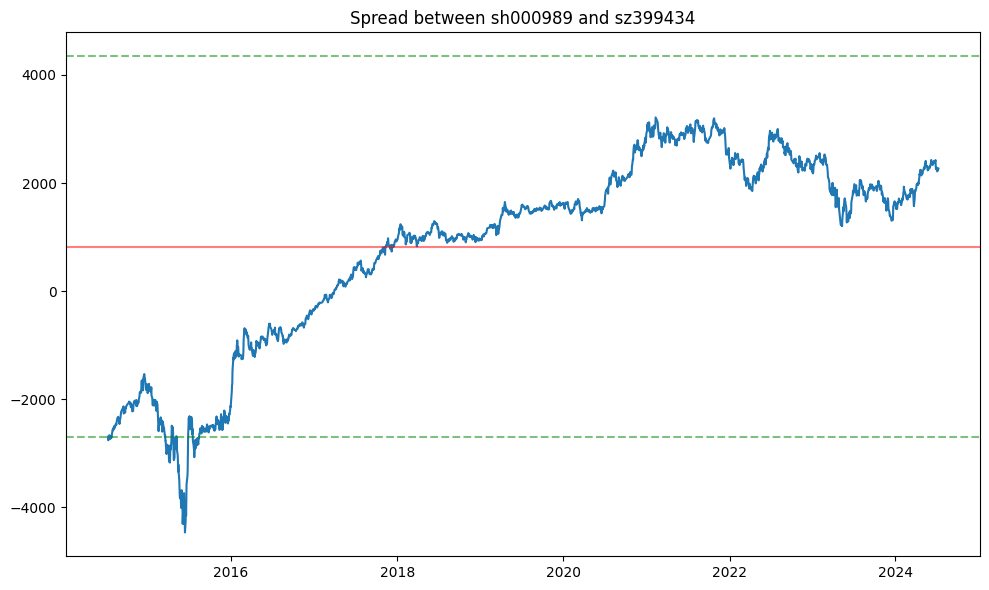

'sh000849', 'sz399971' are cointegrated
Hedge ratio: 5.0331


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


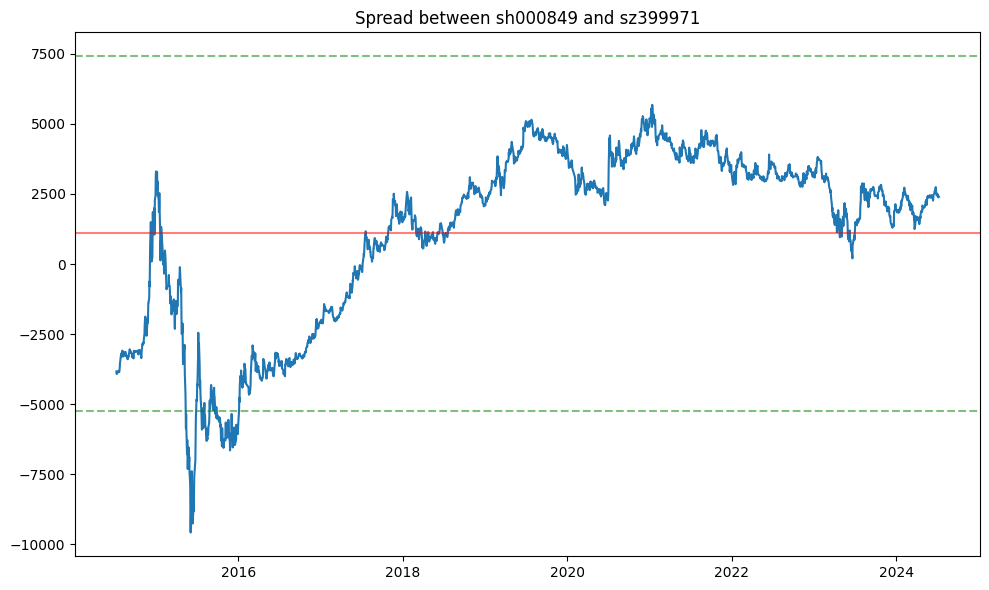

'sh000849', 'sz399242' are cointegrated
Hedge ratio: 5.1427


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


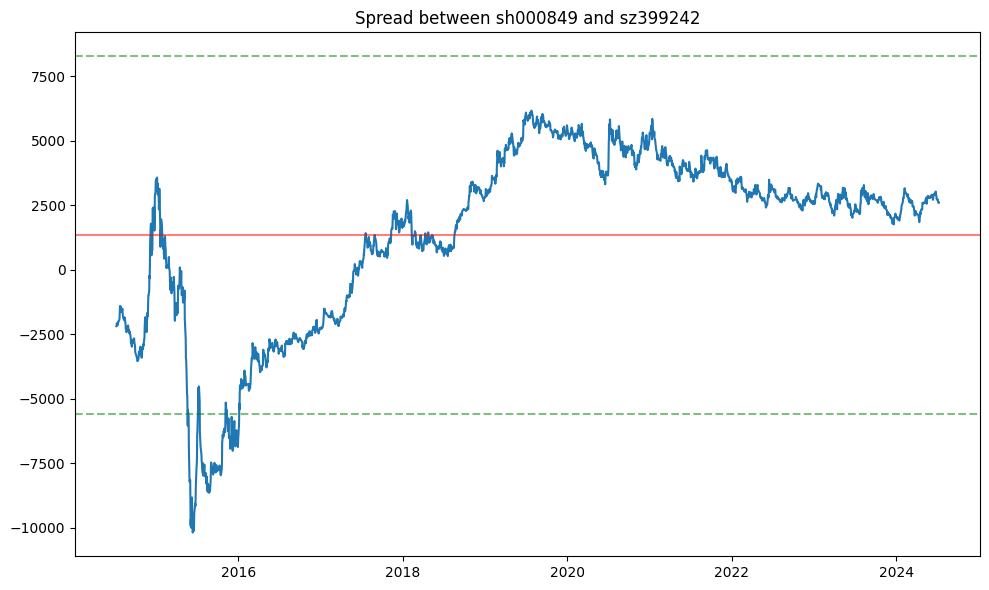

'sh000849', 'sz399326' are cointegrated
Hedge ratio: 1.7646


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


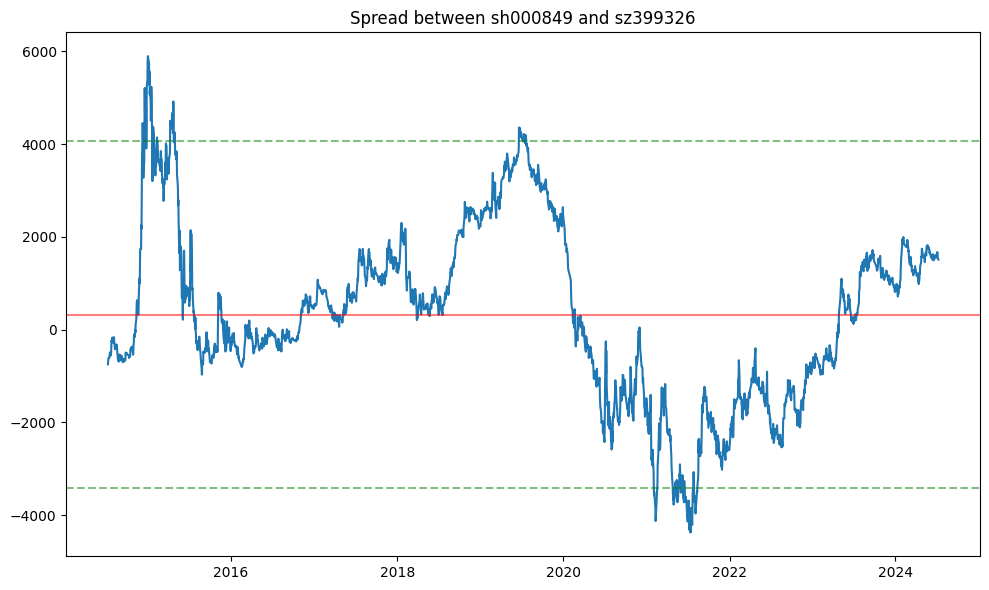

'sh000849', 'sz399434' are cointegrated
Hedge ratio: 2.6697


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


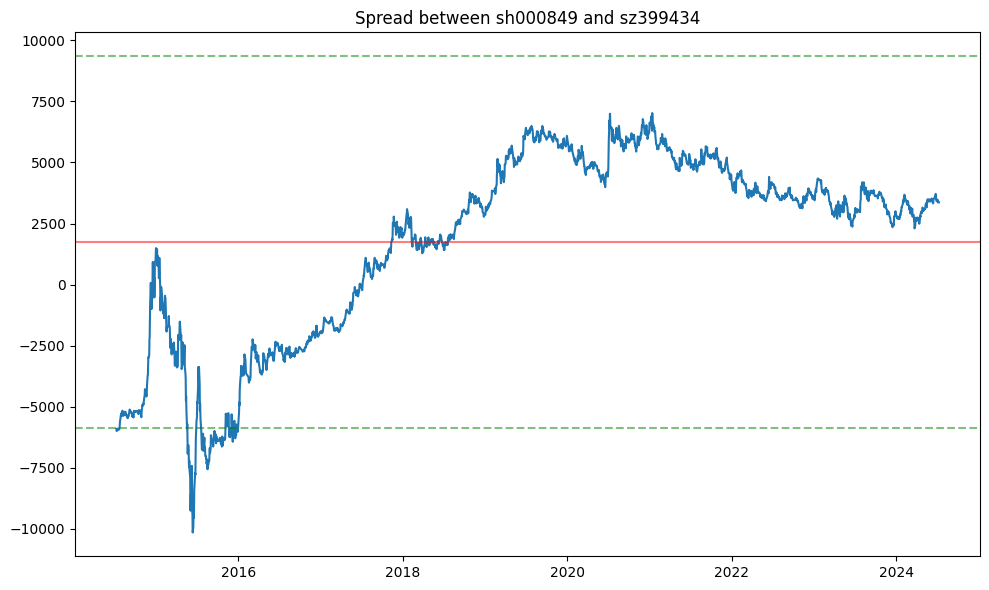

'sz399971', 'sz399242' are cointegrated
Hedge ratio: 1.0346


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


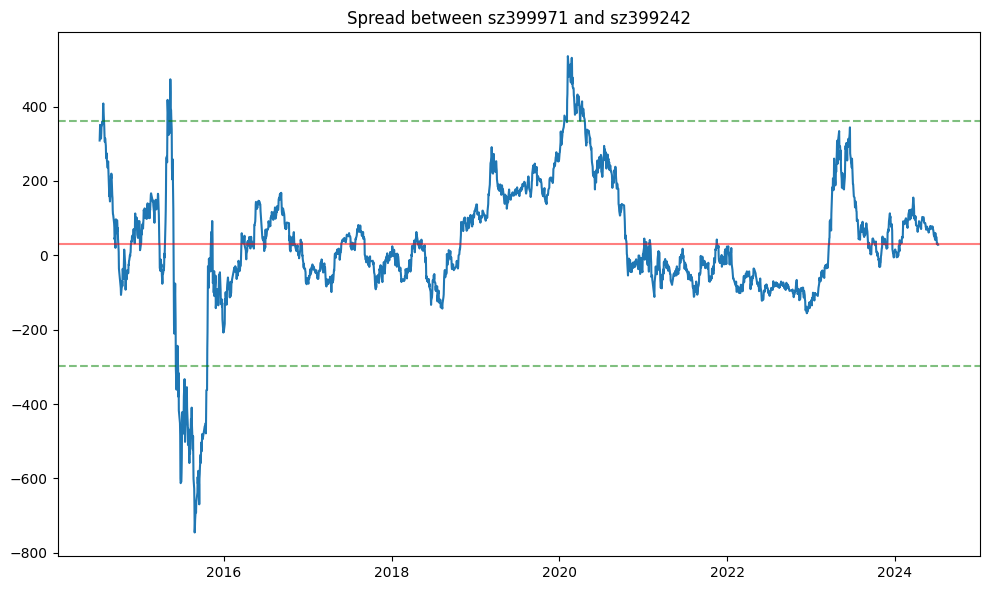

'sz399971', 'sz399434' are cointegrated
Hedge ratio: 0.5490


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


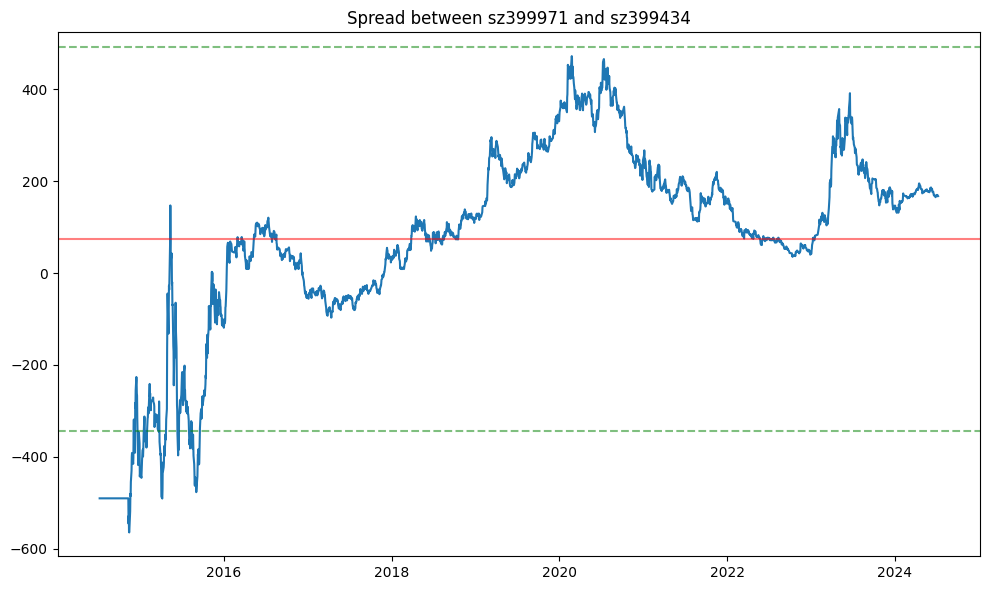

'sh000053', 'sz399242' are cointegrated
Hedge ratio: 5.5197


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


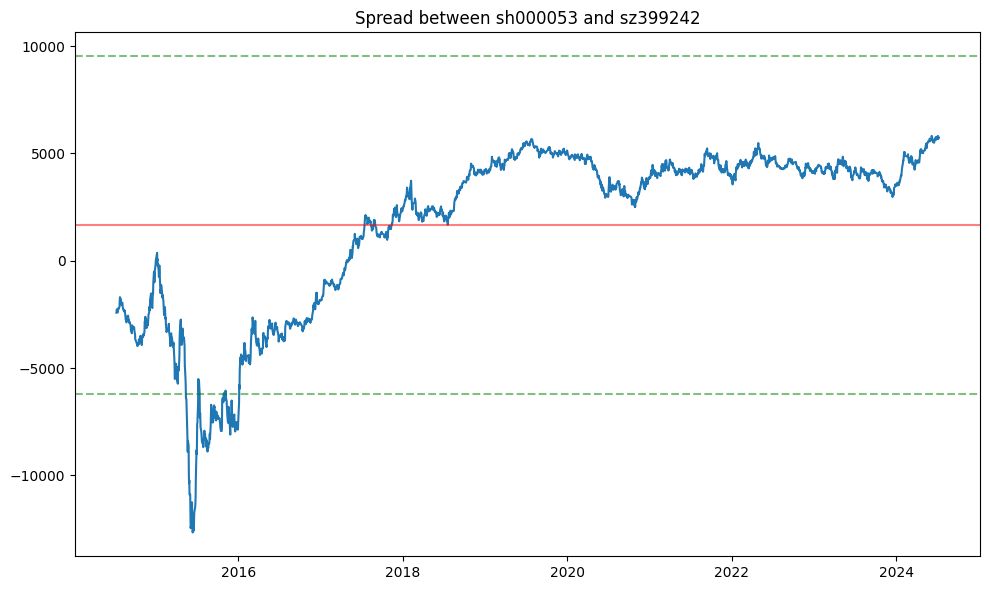

'sh000053', 'sz399303' are cointegrated
Hedge ratio: 1.3299


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


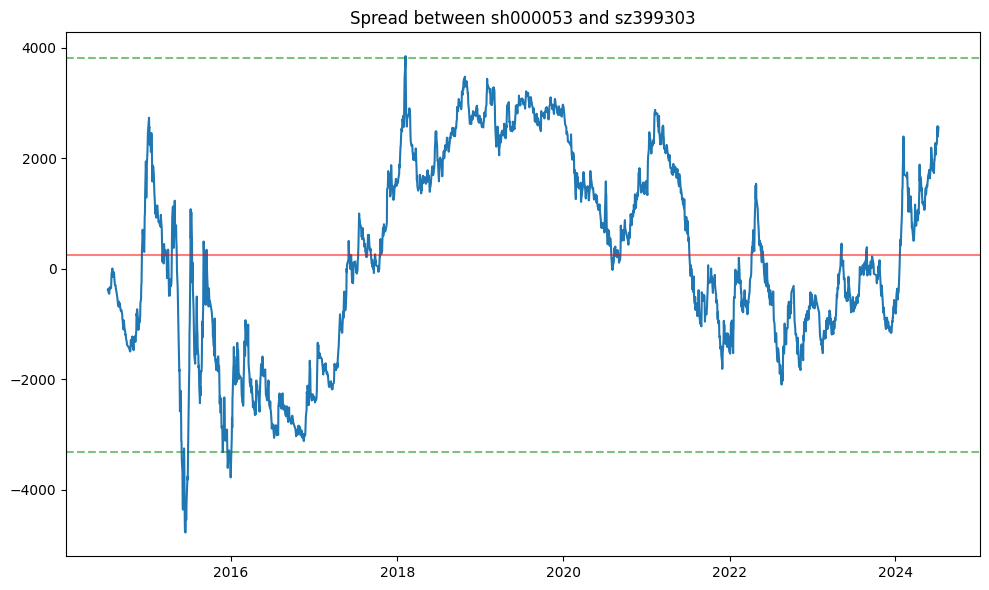

'sh000053', 'sz399326' are cointegrated
Hedge ratio: 1.9092


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


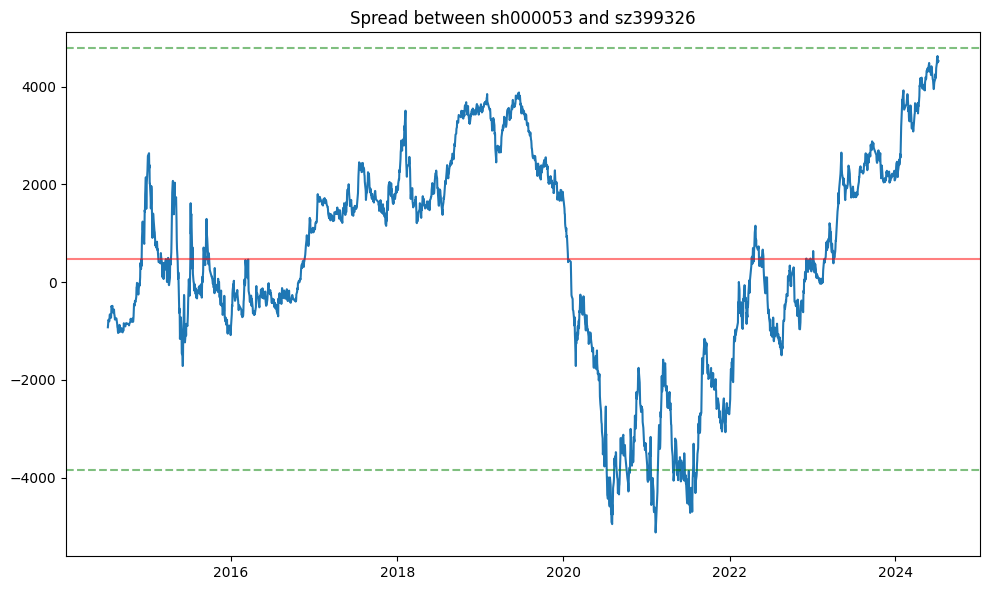

'sh000053', 'sz399434' are cointegrated
Hedge ratio: 2.8472


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


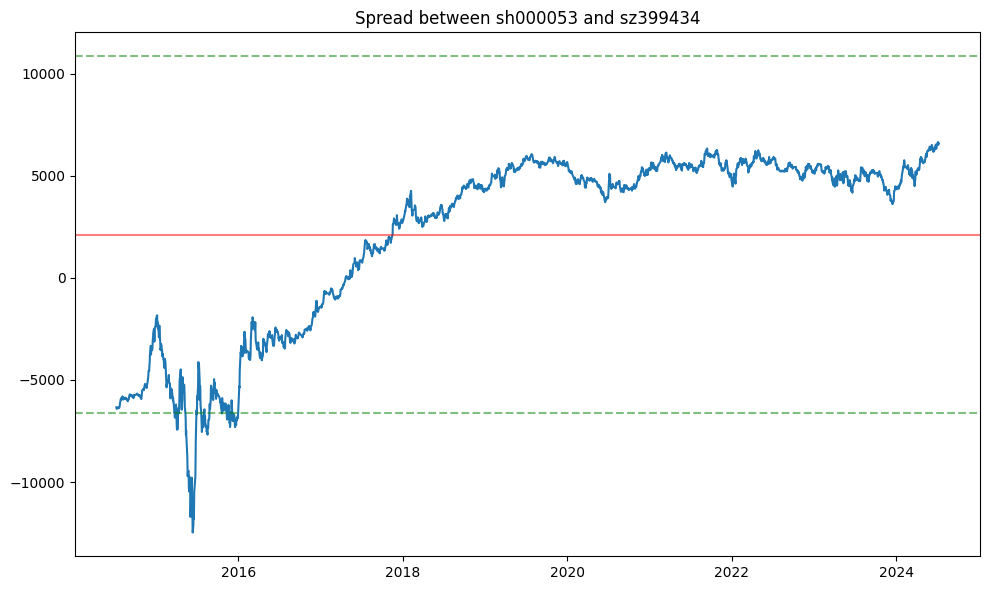

'sz399242', 'sz399434' are cointegrated
Hedge ratio: 0.5289


/tmp/ipykernel_2598282/3289923253.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


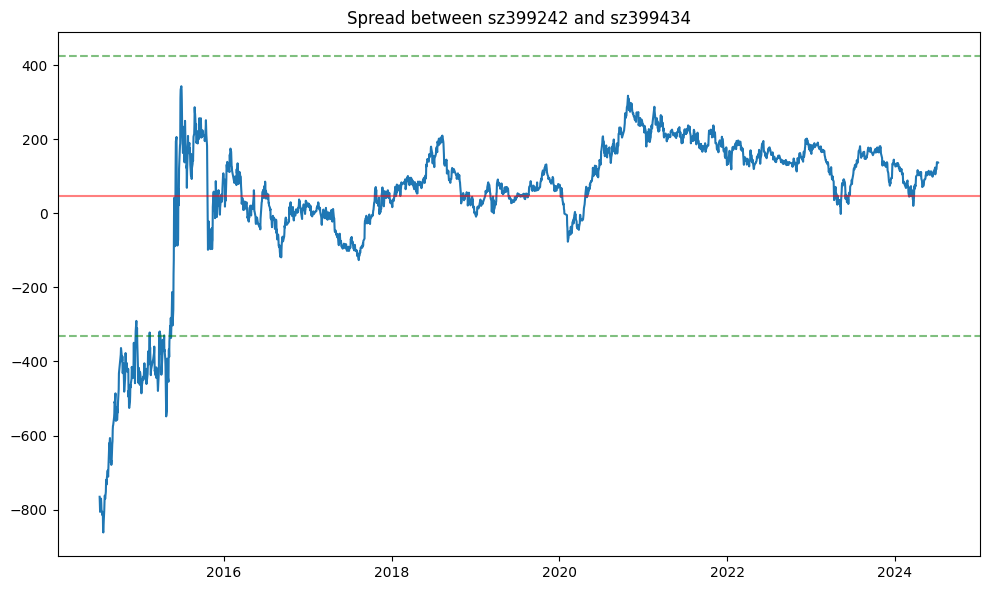


Summary of Cointegrated Pairs:
      Stock1    Stock2   p-value
33  sz399242  sz399434  0.000276
20  sz399615  sz399973  0.000793
27  sz399971  sz399242  0.002019
32  sh000053  sz399434  0.002936
18  sz399239  sz399242  0.003049
29  sh000053  sz399242  0.003609
19  sz399239  sz399434  0.003654
17  sz399239  sz399971  0.005334
28  sz399971  sz399434  0.007669
13  sz399996  sz399973  0.009132
31  sh000053  sz399326  0.009623
5   sz399373  sz399971  0.010258
7   sz399373  sz399242  0.010871
8   sz399373  sz399434  0.010891
9   sz399992  sz399242  0.010919
10  sz399992  sz399434  0.011508
22  sh000989  sz399434  0.017169
15  sz399996  sz399434  0.018943
0   sz399373  sh000079  0.019306
2   sz399373  sz399992  0.021409
11  sz399996  sz399277  0.023220
16  sz399358  sz980032  0.025430
14  sz399996  sz399242  0.026207
3   sz399373  sz399239  0.026254
1   sz399373  sz399433  0.026932
30  sh000053  sz399303  0.027521
21  sh000989  sz399242  0.030362
12  sz399996  sz980032  0.034186
26  sh00084

<Figure size 1200x800 with 0 Axes>

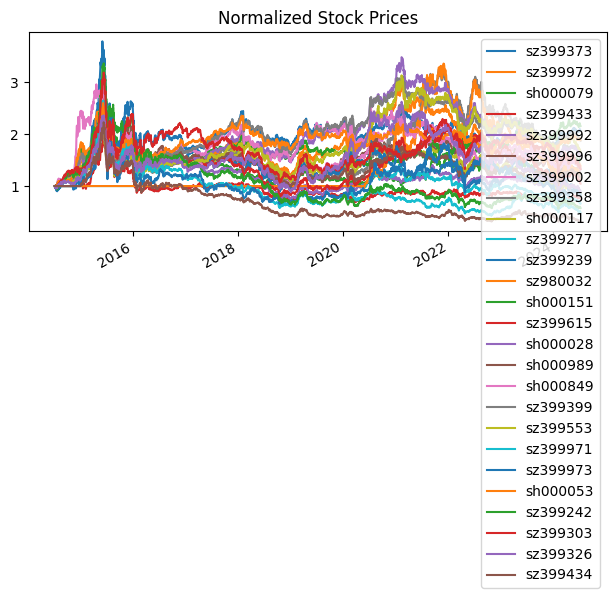

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
from datetime import datetime, timedelta
from quant_free.dataset.equity_load import *

def download_stock_data(tickers,
                        period='2y',
                        start_date = '2012-01-29',
                        end_date = '2024-07-08',
                        market='us',
                        equity='equity',
                        dir_option = 'xq'):
    """Download stock data for the given tickers"""

    data = multi_sym_daily_trade_load(
                                market=market,
                                symbols = tickers, 
                                start_date = start_date, 
                                end_date = end_date,
                                equity = equity,
                                dir_option = dir_option, 
                                column_option = 'close')

    return pd.DataFrame(data)

def test_stationarity(series, ticker_name):
    """Test if a time series is stationary using ADF test"""
    result = adfuller(series.dropna())
    print(f"ADF Test for {ticker_name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] > 0.05:
        print(f"{ticker_name} is non-stationary (has unit root)")
    else:
        print(f"{ticker_name} is stationary")
    print("-" * 40)
    
    return result[1] > 0.05

def check_cointegration_pair(stock1, stock2, stock1_name, stock2_name):
    """Check cointegration between two stock price series"""
    # Ensure same length
    common_index = stock1.index.intersection(stock2.index)
    s1 = stock1.loc[common_index]
    s2 = stock2.loc[common_index]
    
    # Drop NAs
    mask = ~(np.isnan(s1) | np.isnan(s2))
    s1 = s1[mask]
    s2 = s2[mask]
    
    # Perform cointegration test
    score, pvalue, _ = coint(s1, s2)
    
    # print(f"Cointegration Test: {stock1_name} vs {stock2_name}")
    # print(f"Test Statistic: {score:.4f}")
    # print(f"p-value: {pvalue:.4f}")
    
    if pvalue < 0.05:
        print(f"'{stock1_name}', '{stock2_name}' are cointegrated")
        # Calculate hedge ratio
        model = OLS(s1, s2).fit()
        hedge_ratio = model.params[0]
        print(f"Hedge ratio: {hedge_ratio:.4f}")
        
        # Plot the spread
        spread = s1 - hedge_ratio * s2
        plt.figure(figsize=(10, 6))
        plt.plot(spread)
        plt.title(f"Spread between {stock1_name} and {stock2_name}")
        plt.axhline(y=spread.mean(), color='r', linestyle='-', alpha=0.5)
        plt.axhline(y=spread.mean() + 2*spread.std(), color='g', linestyle='--', alpha=0.5)
        plt.axhline(y=spread.mean() - 2*spread.std(), color='g', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    # else:
    #     print(f"No evidence of cointegration between {stock1_name} and {stock2_name}")
    
    # print("-" * 40)
    return pvalue < 0.05, pvalue

def find_cointegrated_pairs(data, significance=0.05):
    """Find all cointegrated pairs in a DataFrame of stock prices"""
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    pairs = []
    
    # Format for storing results
    results = []
    
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
            stock1_name = data.columns[i]
            stock2_name = data.columns[j]
            
            is_coint, pvalue = check_cointegration_pair(stock1, stock2, stock1_name, stock2_name)
            
            pvalue_matrix[i, j] = pvalue
            
            if is_coint:
                pairs.append((stock1_name, stock2_name))
                results.append({
                    'Stock1': stock1_name,
                    'Stock2': stock2_name,
                    'p-value': pvalue
                })
    
    return pairs, pvalue_matrix, pd.DataFrame(results)

def main():
    # Example: Testing for cointegration between stocks
    tickers = ["sz399373", "sz399972", "sh000079", "sz399433", "sz399992", "sz399996", "sz399002", "sz399358", "sh000117", "sz399277", "sz399239", "sz980032", "sh000151", "sz399615", "sh000028", "sh000989", "sh000849", "sz399399", "sz399553", "sz399971", "sz399373", "sz399973", "sh000053", "sz399242", "sz399303", "sz399326", "sh000079", "sz399434"]
    # tickers=['sz399972', 'sh000028']
    
    print(f"Downloading data for {tickers}...")
    data = download_stock_data(tickers,
                               start_date = '2014-07-08',
                               end_date = '2024-07-08',
                               market='cn',
                               equity='index',
                               dir_option = '',)
    
    # Check stationarity of each stock
    # print("\nStationarity Tests:")
    # for ticker in tickers:
    #     test_stationarity(data[ticker], ticker)
    
    # Find all cointegrated pairs
    print("\nCointegration Analysis:")
    pairs, pvalue_matrix, results_df = find_cointegrated_pairs(data)
    
    print("\nSummary of Cointegrated Pairs:")
    if len(pairs) > 0:
        print(results_df.sort_values('p-value'))
    else:
        print("No cointegrated pairs found")
    
    # Plot all stock prices (normalized)
    plt.figure(figsize=(12, 8))
    normalized_data = data / data.iloc[0]  # Normalize to starting point
    normalized_data.plot()
    plt.title('Normalized Stock Prices')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()